<a href="https://colab.research.google.com/github/MilenaBaldeva/E-Commerce_Sales_Analysis/blob/main/Sales_Analysis_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Data

In [1]:
# Import the necessary libraries
import pandas as pd

# Define the file path
file_path = "/content/Online_Retail.xlsx"

# Load the dataset
df = pd.read_excel(file_path)

# Display the first 5 rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Cleaning

In [2]:
# Checking for missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [3]:
#Cheking the Data Shape
df.shape

(541909, 8)

In [4]:
# Checking for duplicates
df.duplicated().sum()

np.int64(5268)

In [5]:
# Remove duplicates
df = df.drop_duplicates()

In [6]:
# Checking for duplicates again
df.duplicated().sum()

np.int64(0)

In [7]:
# Fill Missing Descriptions Using StockCode
df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

<ipython-input-7-4a07cb15918d>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-7-4a07cb15918d>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [8]:
# Checking again for missing Description values
df['Description'].isnull().sum()


np.int64(112)

In [9]:
# Fill missing descriptions with "Unknown"
df['Description'].fillna('Unknown', inplace=True)

<ipython-input-9-f9a89d5d56a1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Unknown', inplace=True)


In [10]:
# Fill missing CustomerID with a placeholder
df['CustomerID'].fillna(0, inplace=True)  # Placeholder for missing IDs

<ipython-input-10-99e8806d4c66>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustomerID'].fillna(0, inplace=True)  # Placeholder for missing IDs


In [11]:
# Check missing values again
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [12]:
# Check for Data Types of All Columns
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [13]:
# Check for negative Quantity (Cancelations)
negative_count = (df['Quantity'] < 0).sum()
print(f"Number of rows with negative Quantity: {negative_count}")

Number of rows with negative Quantity: 10587


In [14]:
# Create a new column 'TransactionType' based on Quantity
df['TransactionType'] = df['Quantity'].apply(lambda x: 'Cancelation' if x < 0 else 'Purchase')

In [ ]:
# Save cleaned dataset
df.to_csv("cleaned_online_retail.csv", index=False)

# Customer Segmentation

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Creating a column 'TotalPrice'
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# Compute RFM values
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(1)
rfm = df[df['CustomerID'] != 0].groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm)

# Save RFM data
rfm.to_csv("customer_segments.csv")

# Sales Forecasting & Predictive Analytics

In [15]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [16]:
# Converting the data into Prophet format

# Aggregate daily sales
df_sales = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()

# Rename columns for Prophet
df_sales.columns = ['ds', 'y']

# Convert 'ds' to datetime format
df_sales['ds'] = pd.to_datetime(df_sales['ds'])

# Display the first few rows
df_sales.head()

,ds,y
0,2010-12-01,26713
1,2010-12-02,20958
2,2010-12-03,14789
3,2010-12-05,16187
4,2010-12-06,21243


In [17]:
# Train the Prophet Model

# Initialize Prophet model with additional seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model
model.fit(df_sales)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry1x915/jqnm88p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry1x915/iyhzvf7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67945', 'data', 'file=/tmp/tmpkry1x915/jqnm88p7.json', 'init=/tmp/tmpkry1x915/iyhzvf7t.json', 'output', 'file=/tmp/tmpkry1x915/prophet_model4jn47nws/prophet_model-20250320172957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
# Create future dates (365 days ahead)
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Display forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
665,2012-12-04,33039.544641,25425.364862,40682.906194
666,2012-12-05,32271.162816,24391.309981,40124.900242
667,2012-12-06,35561.624444,28073.899303,43443.057409
668,2012-12-07,28713.638817,20745.136154,36902.614826
669,2012-12-08,36213.596392,28337.736292,43949.371248


In [20]:
# Save the Predictions to Csv File
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("sales_forecast.csv", index=False)


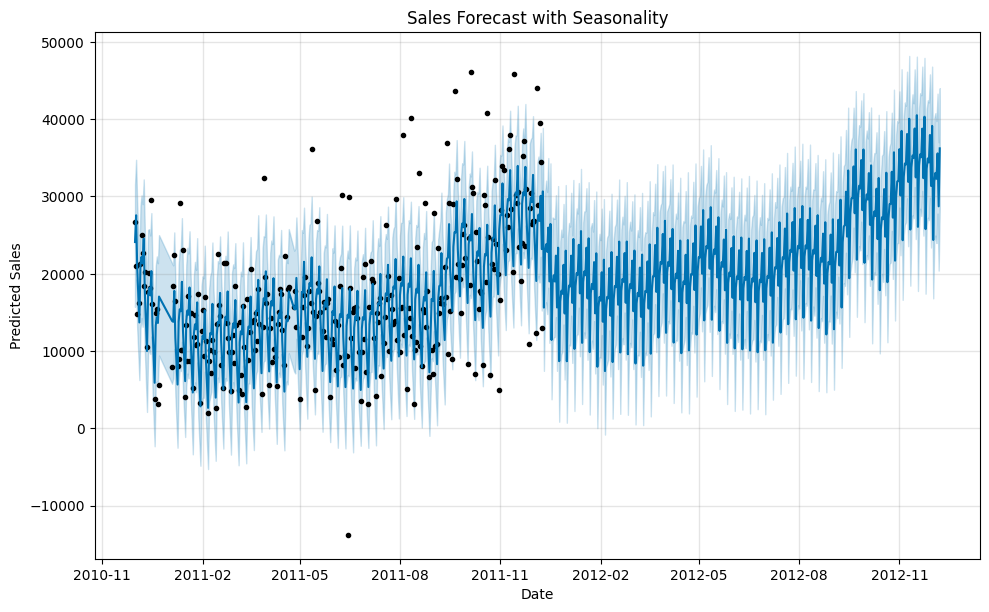

In [ ]:
# Plot the forecast
fig = model.plot(forecast)
plt.title("Sales Forecast with Seasonality")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.show()


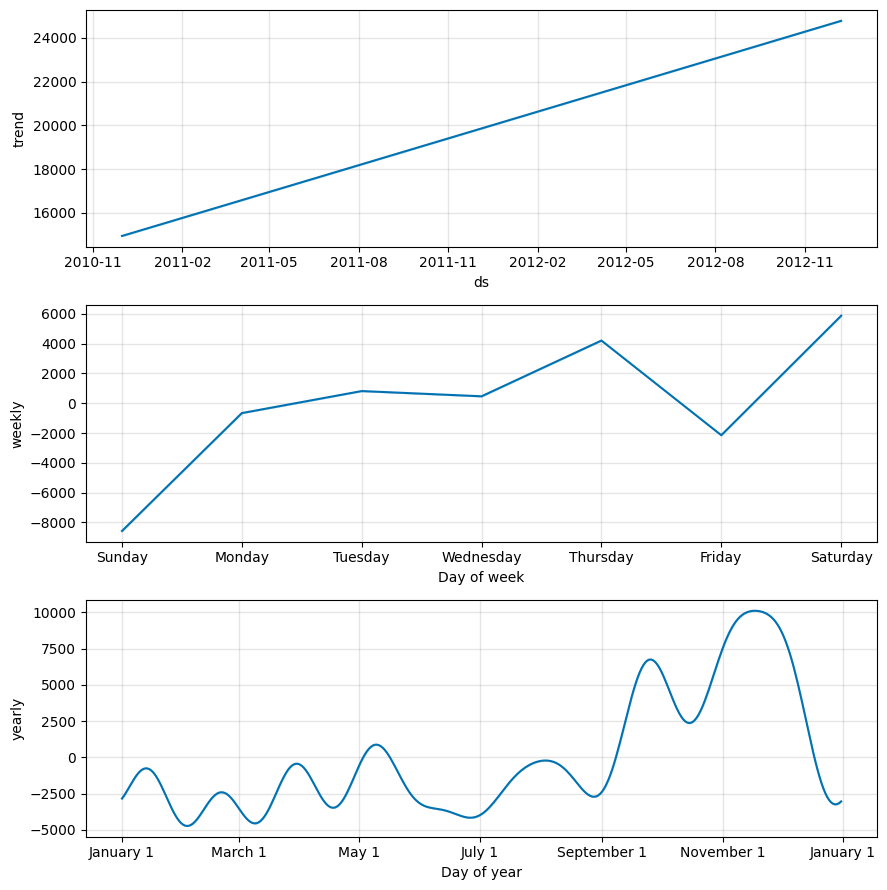

In [ ]:
# Show trend, weekly, and yearly seasonality
fig2 = model.plot_components(forecast)

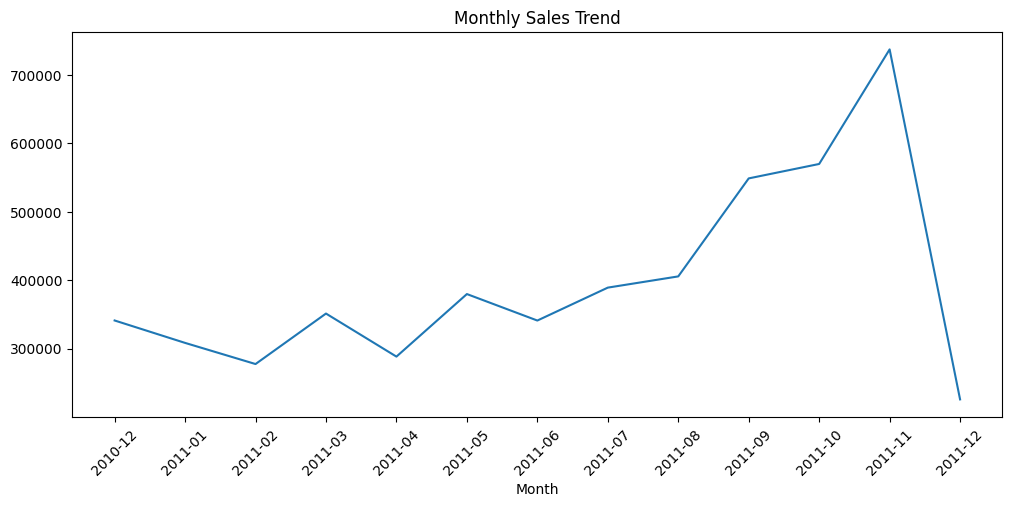

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Total Sales over Time
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Quantity'].sum()

plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_sales.index.astype(str), y=monthly_sales.values)
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.show()
